### MIT Shocks

- The general principle is to consider an economy that is at its steady-state in period $t$.

- Then we expose the economy to some temporary shock, under the assumption that the economy will fully have reverted back to its steady-state in period $t + T$.

- Then it’s not that hard to calculate the transition of the economy between period $t$ and $t + T$. Just compute the perfect foresight transition back to steady state!

#### Algorithm

- General principle: Guess how the capital stock will evolve from period $t + 1$ to period $t + T$ , assuming that
it’s back to it’s steady state value in $t + T + 1$. Call this guess$\{k_{t+s}^0 \}^T_{s=1}$.


- Given this guess, we can calculate wages and interest rates as $w^0_{t+s} = exp(z_{t+s})F_n(k^0_t,n)$ and
$\tilde{r}^0_{t+s} = exp(z_{t+s})F_k(k^0_t,n)$


- Using time iteration again, we can find $\tilde{g}(a, s)$ as
$$u^\prime((1+r^0_{t+s} )a+w^0_{t+s}−\tilde{g}(a,s)) = β(1 + r^0_{t+s+1}) \sum_{s^\prime} u^\prime((1 + r^0_{t+s+1} )\tilde{g}(a, s) + w^0_{t+s+1} − g^0_{t+s+1} (\tilde{g}(a, s), s′))p(s′, s)$$


- Then $g^0_{t+s}(a,s) =  max\{\tilde{g}(a,s), \phi  \}$, with $g_{t+T+1}(a,s)= g(a,s)$


- Then for each $g^0_t, g^0_{t+1} , ..., g^0_{t+s}$ we can find a transition matrix $M^0_{t+s}$


- Given that we know $ψ_t (a, s) = ψ(a, s)$, we can update matrix as $ψ^0_{t+s+1} = ψ^0_{t+s} × M^0_{t+s} $, and calculate the implied aggregate asset holdings $A^0_{t+s}$ 


- Finally Then we update our guess for the sequence of capital as 
$\{k^1_{t+s} \}^T_{s=1} = η\{k^0_{t+s} \}^T_{s=1} + (1 − η)\{A^0_{t+s} \}^T_{s=1}$ with $η ∈ (0, 1]$


- And repeat until $||\{k^{n+1}_{t+s}\}^T_{s=1} − \{k^n_{t+s} \}^T_{s=1}||<\epsilon$

### MIT Shock in Aiyagari Model

In [111]:
# Import Libraries
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
from quantecon.markov import DiscreteDP
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc
plt.style.use({'figure.facecolor':'white'})
rc('text', usetex=True)
%config InlineBackend.figure_format = 'retina'


gamma = 2
mu = 0.5
alpha = 1/3
phi = -1.0
beta = 1.03**(-1/12)
delta = 0.025
a_min = -3.0
a_max = 60.0
A = 1.0
L = 1.0
N = 100

P = np.array([[0.4,0.6], [0.6, 0.4]])


agrid = np.linspace(a_min,np.log(a_max-phi+1),N)
a_vals = np.exp(agrid)+phi-1


def rd(K, A = 1.0):
    return A * alpha * (L / K)**(1 - alpha) - delta

def r_to_w(r, A = 1.0):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - alpha) * (A * alpha / (r + delta))**(alpha / (1 - alpha))

def policy(r0, w0, r1, w1):
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals
    metric = 1
    
    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
        ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)
        
        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb


def makeTransition_M(gg, gb):
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = a_vals[-1], bounds_error=False);
    a1gd_star = F(np.maximum(gg(a_vals),phi));
    a1bd_star = F(np.maximum(gb(a_vals),phi));

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):
    
        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]
    
        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1.0
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            if Tb[i,ixb] > 1:
                Tb[i,ixb] = 1.0
            Tb[i,ixb-1] = 1-Tb[i,ixb]

        
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)

    return M

def GetStationaryDist(M):
    eval,evec = np.linalg.eig(M.T)
    i = np.argmin(np.abs(eval-1.0))
    D = np.array(evec[:,i]).flatten()
    assert np.max(np.abs(np.imag(D))) < 1e-6
    D = np.real(D)  # just recasts as float
    return D/D.sum()

def agr_capital(dist):
    a_dist = dist[0:N]+dist[N:]
    return np.dot(a_vals.T, a_dist)

def prices_to_capital(r):
    gg, gb = policy(r, r_to_w(r), r, r_to_w(r))
    M = makeTransition_M(gg,gb)
    dist = GetStationaryDist(M)
    K = agr_capital(dist)
    return K

def equilibrium_ss():
    res = lambda K: K - prices_to_capital(rd(K))
    Kss_certain =  ((1/beta-1+delta)/alpha)**(1./(alpha-1))
    sol  = opt.root_scalar(res, bracket = [0.8*Kss_certain,1.2*Kss_certain], method = 'brentq').root
    return sol


def policy_back(r0, w0, r1, w1, gg, gb):
    ag1 = a_vals
    ab1 = a_vals
    ag = a_vals
    ab = a_vals

    Eg = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
    Eb = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

    ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
    ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)

    gg1 = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
    gb1 = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

    return gg1, gb1

In [112]:
Kss = equilibrium_ss()

In [113]:
Kss

42.02763059117256

In [114]:
r = rd(Kss)
w = r_to_w(r)
gg, gb = policy(r, w, r, w)
M = makeTransition_M(gg, gb)
dist = GetStationaryDist(M)

In [115]:
M.T.shape

(200, 200)

In [116]:
dist.shape

(200,)

### TFP Shock

In [117]:
s = 50
As = np.ones(s+1)*1.0
As[0] = 1.01

In [118]:
# Guess K sequence
K0s = np.ones(s+1)*Kss

gg_ss, gb_ss = policy(rd(Kss), r_to_w(rd(Kss)), rd(Kss), r_to_w(rd(Kss)))

In [119]:
# Update Prices
rs = rd(K0s, As)
    
ws = r_to_w(rs, As)

rs

array([0.00285117, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542, 0.00257542, 0.00257542, 0.00257542, 0.00257542,
       0.00257542])

In [120]:
# Update Policies
ggs = [None] * s
ggs.insert(s, gg_ss)

gbs = [None] * s
gbs.insert(s, gb_ss)

for i in range(s,0,-1):
    r1 = rd(K0s[i], As[i])
    r0 = rd(K0s[i-1], As[i-1])
    w1 = r_to_w(r1, As[i])
    w0 = r_to_w(r0, As[i-1])
    gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
    ggs[i-1] = gg1
    gbs[i-1] = gb1

In [121]:
# Update Transition Matrices
Ms = [None]*s

for i in range(0,s,1):
    Ms[i]= makeTransition_M(ggs[i], gbs[i])

In [122]:
# Update Distributions
dists = [None]*s

for i in range(0,s,1):
    dists[i] = np.dot(dist, Ms[i])

In [123]:
# Update Aggregates
K1s = [None]*s
K1s.insert(s, Kss)

for i in range(0,s,1):
    K1s[i] = agr_capital(dists[i])

In [124]:
def update_agreggates(K0s):
    # Update Prices
    rs = rd(K0s, As)

    ws = r_to_w(rs, As)
    
    # Update Policies
    ggs = [None] * s
    ggs.insert(s, gg_ss)

    gbs = [None] * s
    gbs.insert(s, gb_ss)

    for i in range(s,0,-1):
        r1 = rd(K0s[i], As[i])
        r0 = rd(K0s[i-1], As[i-1])
        w1 = r_to_w(r1, As[i])
        w0 = r_to_w(r0, As[i-1])
        gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
        ggs[i-1] = gg1
        gbs[i-1] = gb1
        
    Ms = [None]*s

    for i in range(0,s,1):
        Ms[i]= makeTransition_M(ggs[i], gbs[i])
        
    # Update Distributions
    dists = [None]*s

    for i in range(0,s,1):
        dists[i] = np.dot(dist, Ms[i])
        
    K1s = [None]*s
    K1s.insert(s, Kss)

    for i in range(0,s,1):
        K1s[i] = agr_capital(dists[i])
    
    return np.array(K1s), ggs, gbs, dists

In [125]:
def equilibrium_trans(Kguess):
    for i in range(0,s):
        aggK, ggs, gbs, dists = update_agreggates(Kguess)
        dif = max(abs(Kguess-aggK))
        print(dif)
        if dif < 1e-6:
            return aggK, ggs, gbs, dists
        Kguess = 0.2*aggK + 0.8*Kguess

    print("Did not converge")

aggK, ggs, gbs, dists = equilibrium_trans(K0s)

0.026196390876691567
0.02093570668505862
0.016731467098601627
0.013371514824818576
0.010686299609808714
0.008540321137694207
0.006825290674754569
0.00545466618182644
0.004359285000582247
0.0034838736531028758
0.0027842585839792378
0.002225137064392868
0.001778295755521242
0.0014211870263025617
0.0011357911775888851
0.0009077071547309856
0.0007254258627398258
0.0005797494129922143
0.00046332699567841473
0.0003702839568973104
0.0002959253632255354
0.00023649909560674587
0.00018900651749476083
0.0001510511640248069
0.00012071781681299854
9.64758621648798e-05
7.710205677824433e-05
6.161880304489387e-05
4.924481962831351e-05
3.935571825763873e-05
3.145249728930821e-05
2.51363620407119e-05
2.008860182911576e-05
1.6054507852913957e-05
1.2830520702777903e-05
1.0253958720340961e-05
8.19480918323734e-06
6.549167913760812e-06
5.233996198228397e-06
4.182930801732709e-06
3.3429351731228962e-06
2.671623327898942e-06
2.1351210435227586e-06
1.7063564996533387e-06
1.363694337896959e-06
1.08984391289368

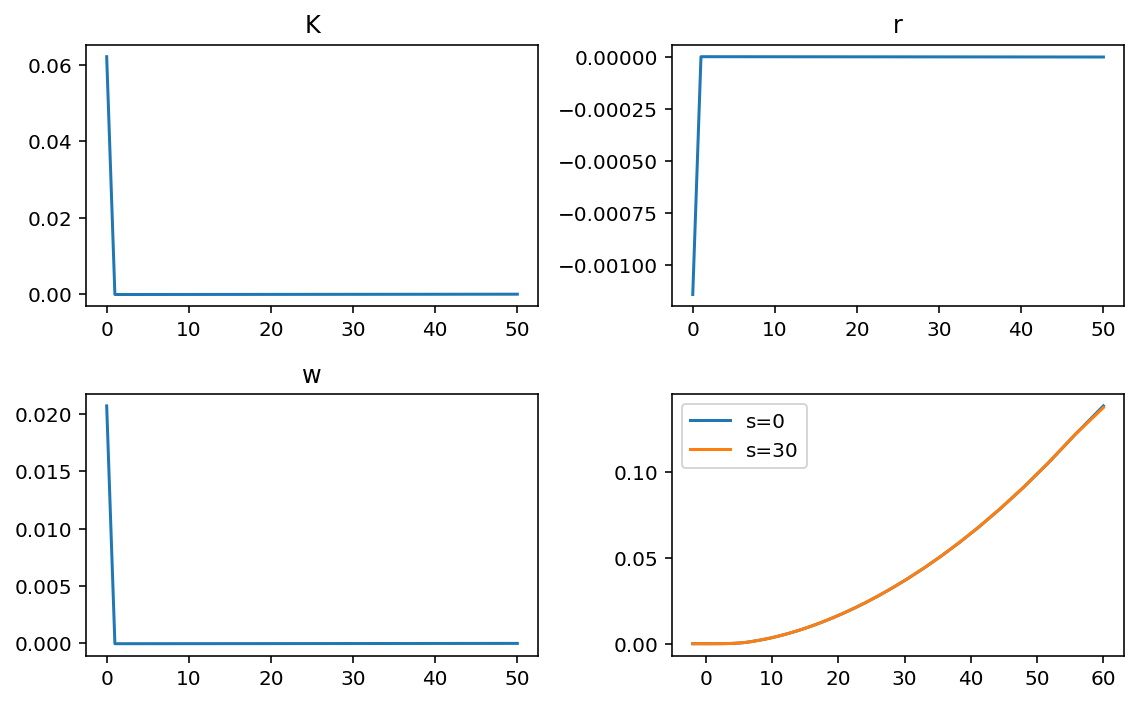

In [62]:
fig, ax = plt.subplots(2,2, figsize = (8,5))
ax[0,0].plot(np.arange(0,s+1), (aggK-Kss)/Kss*100)
ax[0,0].set_title('K')
ax[0,1].plot(np.arange(0,s+1), (rd(aggK)-rd(Kss))*100)
ax[0,1].set_title('r')
ax[1,0].plot(np.arange(0,s+1), (r_to_w(rd(aggK))-r_to_w(rd(Kss)))/r_to_w(rd(Kss))*100)
ax[1,0].set_title('w')

ax[1,1].plot(a_vals, dists[0][0:N]+dists[0][N:], label = 's=0')
ax[1,1].plot(a_vals, dists[30][0:N]+dists[30][N:], label = 's=30')
ax[1,1].legend()
plt.tight_layout()
plt.show()

### Adding more persistence to shock

In [153]:
s = 50
epsilons = np.ones(s+1)*0
epsilons[0] = 0.02

def A(A0, epsilon, rho = 0.5):
    return 1-rho + rho*A0 + epsilon

As = [1.0]

for i in range(0,s):
    As.append(A(As[i], epsilons[i], rho=0.8))
    
As = np.array(As)

In [154]:
# Guess K sequence
K0s = np.ones(s+1)*Kss

gg_ss, gb_ss = policy(rd(Kss), r_to_w(rd(Kss)), rd(Kss), r_to_w(rd(Kss)))

In [155]:
aggK, ggs, gbs, dists = equilibrium_trans(K0s)

0.05368624665560873
0.042889365273389046
0.03426389322024903
0.027373113942807947
0.021868149191433872
0.017470289862544064
0.013956881796559628
0.011150051029993335
0.00890769710567696
0.00711629808849068
0.00568516279564335
0.004541839103133327
0.003628445775071043
0.002898742051506531
0.0023157866027787577
0.001850067309391079
0.001478007172387663
0.0011807707048419047
0.0009433103727047865
0.000753604806426722
0.0006020502159529428
0.00048097419742987313
0.00038424731777553234
0.000306972812524009
0.0002452386878601942
0.00019591967662080378
0.0001565190225818469
0.00012504208285690765
9.989534952126178e-05
7.980577908028863e-05
6.37563449430445e-05
5.093455077798126e-05
4.0691298394790465e-05
3.250802715371037e-05
2.5970462182556275e-05
2.0747641805485273e-05
1.6575162796073073e-05
1.3241795066676332e-05
1.0578788156578867e-05
8.451328362468757e-06
6.751713883090815e-06
5.393902398509454e-06
4.309155201553949e-06
3.442557350297193e-06
2.7502376980237386e-06
2.197147843219227e-06
1

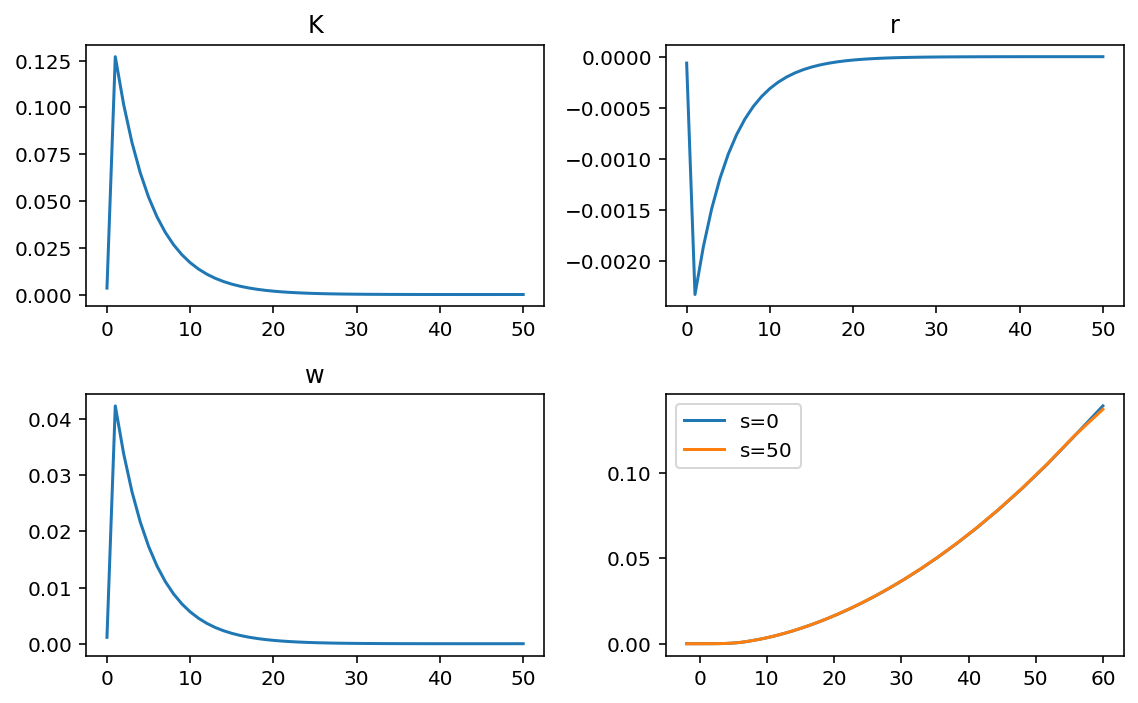

In [156]:
fig, ax = plt.subplots(2,2, figsize = (8,5))
ax[0,0].plot(np.arange(0,s+1), (aggK-Kss)/Kss*100)
ax[0,0].set_title('K')
ax[0,1].plot(np.arange(0,s+1), (rd(aggK)-rd(Kss))*100)
ax[0,1].set_title('r')
ax[1,0].plot(np.arange(0,s+1), (r_to_w(rd(aggK))-r_to_w(rd(Kss)))/r_to_w(rd(Kss))*100)
ax[1,0].set_title('w')

ax[1,1].plot(a_vals, dists[1][0:N]+dists[1][N:], label = 's=0')
ax[1,1].plot(a_vals, dists[49][0:N]+dists[49][N:], label = 's=50')
ax[1,1].legend()
plt.tight_layout()
plt.show()